In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

### Convert images from Pillow images (range [0,1]) to Tensors of range [-1,1] 

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
#trainset = torchvision.datasets.CIFAR10()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

In [6]:
testset=torchvision.datasets.CIFAR10(root='./data',train=False,
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Verifying by displaying some images

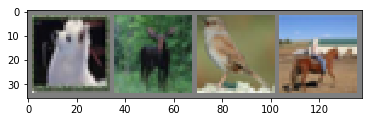

  dog  deer  bird horse


In [8]:
import matplotlib.pyplot as plt
import numpy as np
# function to display an image
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#Obtain random training images
dataiter =iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define a Convolutional NN

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x= x.view(-1,16*5*5)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return x
net=Net()


### Define the loss function

In [11]:
import torch.optim as optim 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### Train the network

In [13]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get inputs
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs=net(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print stats
        running_loss += loss.item()
        if i% 2000 == 1999:    #print every 2000 th mini-batch
            print('[%d, %5d] loss: %3f' %(epoch + 1,i + 1, running_loss/2000))
            running_loss = 0.0
print('Finished Training')
        

[1,  2000] loss: 2.298929
[1,  4000] loss: 2.024573
[1,  6000] loss: 1.750928
[1,  8000] loss: 1.609753
[1, 10000] loss: 1.535640
[1, 12000] loss: 1.480742
[2,  2000] loss: 1.402203
[2,  4000] loss: 1.375466
[2,  6000] loss: 1.356157
[2,  8000] loss: 1.327228
[2, 10000] loss: 1.316729
[2, 12000] loss: 1.287554
Finished Training


### Check by predicting class label on Test data

#### Display image from test set

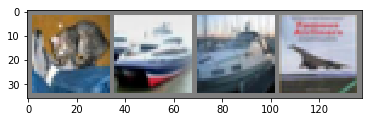

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'% classes[labels[j]] for j in range(4)))


#### Deploy the Neural Network on the test image

In [16]:
outputs=net(images)
_, predicted = torch.max(outputs, 1) #Get index of highest excited neuorn 
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))


Predicted:    cat  ship  ship plane


In [17]:
# Let us evaluate the network performance on whole data set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [20]:
# Let's see which classes performed well
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 65 %
Accuracy of  bird : 38 %
Accuracy of   cat : 50 %
Accuracy of  deer : 41 %
Accuracy of   dog : 47 %
Accuracy of  frog : 66 %
Accuracy of horse : 61 %
Accuracy of  ship : 68 %
Accuracy of truck : 62 %


#### Training on GPU

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [22]:
# But if we had a CUDA device, we would have done the following
net.to(device)  #CUDA instead of GPU
inputs, labels = inputs.to(device), labels.to(device)
# We have to send the inputs and targets to every step to GPU